In [63]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer

from scipy.stats import skew

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

data = pd.read_csv("feature_fillna_onehot.csv")

In [64]:
len(data)

2919

In [65]:
df_train = data[data["source"] == "train"]
df_test = data[data["source"] == "test"]

In [66]:
len(df_train)

1460

In [67]:
# Delete price outlier
df_train = df_train[~(df_train["Id"] == 524)]
df_train = df_train[~(df_train["Id"] == 1299)]

In [68]:
len(df_train)

1458

In [69]:
price = df_train["SalePrice"]
y_train = np.log(price)

In [70]:
X_train = df_train.drop("Id", axis = 1)
X_train = X_train.drop("SalePrice", axis = 1)
X_train = X_train.drop("source", axis = 1)
X_test = df_test.drop("Id", axis = 1)
X_test = X_test.drop("SalePrice", axis = 1)
X_test = X_test.drop("source", axis = 1)

In [71]:
len(X_train)

1458

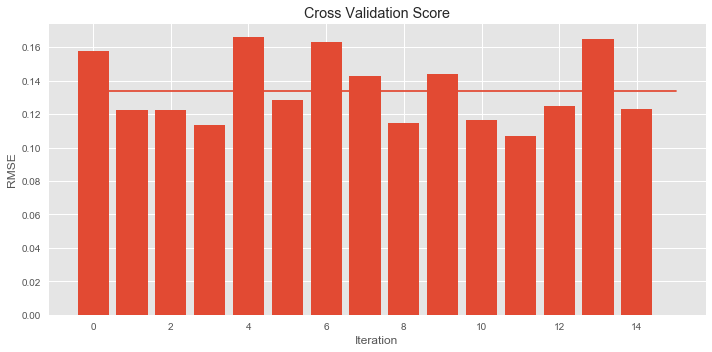

In [72]:
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(mean_squared_error, False)

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
cv_score = np.sqrt(-cross_val_score(estimator=clf, X=X_train, y=y_train, cv=15, scoring = scorer))

plt.figure(figsize=(10,5))
plt.bar(range(len(cv_score)), cv_score)
plt.title('Cross Validation Score')
plt.ylabel('RMSE')
plt.xlabel('Iteration')

plt.plot(range(len(cv_score) + 1), [cv_score.mean()] * (len(cv_score) + 1))
plt.tight_layout()

In [73]:
# Average loss
cv_score.mean()

0.13405776284858223

In [74]:
import xgboost as xgb
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

In [75]:
regr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0.0, learning_rate=0.01,
       max_delta_step=0, max_depth=4, min_child_weight=1.5, missing=None,
       n_estimators=7200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.9, reg_lambda=0.6, scale_pos_weight=1,
       seed=42, silent=1, subsample=0.2)

In [76]:
# Run prediction on the Kaggle test set.
y_pred_xgb = regr.predict(X_test)

In [77]:
y_pred_xgb = np.exp(y_pred_xgb)

In [78]:
# Submission
sub = pd.DataFrame()
sub['Id'] = df_test["Id"]
sub['SalePrice'] = y_pred_xgb
sub.to_csv('submission.csv',index=False)